# PMEmo Dataset - Feed Forward Neural Network
## Essentia Best Valence Mean Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_pmemo_path('processed/annotations/pmemo_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,1,0.150,-0.200
1,4,-0.425,-0.475
2,5,-0.600,-0.700
3,6,-0.300,0.025
4,7,0.450,0.400
...,...,...,...
762,993,0.525,0.725
763,996,0.125,0.750
764,997,0.325,0.425
765,999,0.550,0.750


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_valence_features_mean = pd.read_csv(get_pmemo_path('processed/features/standardised_essentia_best_valence_features.csv'))

# drop Unnamed:0 column
df_essentia_best_valence_features_mean = df_essentia_best_valence_features_mean[df_essentia_best_valence_features_mean.columns[1:]]

df_essentia_best_valence_features_mean

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,lowlevel.zerocrossingrate.mean,rhythm.beats_loudness.mean,rhythm.onset_rate,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,1,-0.290830,-0.161553,-0.674310,0.595025,-0.452851,1.298902,-0.966508,-0.692188,-0.466809,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,0.345904,-0.285526,1.021745,-0.039876,0.671714
1,4,2.148017,2.355089,6.176068,-2.027051,4.119475,1.198675,-0.692793,-0.875022,-2.504826,...,0.004772,0.540440,4.181020,-0.456893,-0.005882,0.576715,-0.285526,0.213223,-0.846705,-0.053671
2,5,4.061978,3.102229,2.654601,-1.162994,2.245453,1.518401,0.480322,0.431641,0.529917,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.305337,-0.203477,-0.535816,-0.846705,-0.907128
3,6,0.609811,1.478902,0.594623,-0.486537,0.191578,1.005714,-0.265029,-1.486659,-1.304917,...,-0.196902,0.386979,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.179551,-0.846705,-0.907128
4,7,-0.407720,-0.322652,-0.043632,0.811939,1.317306,-0.202803,0.343143,1.010394,0.710881,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,0.457974,0.503538,-0.375831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,993,-0.341976,-0.376271,-0.184984,1.446416,0.004970,-0.376761,1.148765,0.172968,-0.030536,...,-0.196902,-0.312361,-0.251295,-0.129750,-0.278709,-0.374009,-0.285526,-0.443708,0.429159,3.825664
763,996,0.208018,-0.004852,-0.227602,2.140284,-0.608213,0.416423,1.123782,0.880366,0.113897,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.535816,-0.483101,-0.814508
764,997,-0.448361,-0.267697,-0.099497,2.052115,-0.313137,-0.577048,-1.869459,0.089641,-0.349415,...,-0.099370,-0.027929,-0.251295,0.099811,-0.278709,-0.150331,-0.285526,0.505638,-0.557852,-0.088299
765,999,-0.296933,0.022632,0.258205,2.324076,0.203926,-1.143870,-1.921844,-0.625854,-0.779872,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.229701,-0.374009,0.288011,-0.535816,0.072929,-0.798329


In [4]:
df_essentia_best_valence_features_mean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 67 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   song_id                                  767 non-null    int64  
 1   lowlevel.melbands_kurtosis.mean          767 non-null    float64
 2   lowlevel.melbands_skewness.mean          767 non-null    float64
 3   lowlevel.spectral_energy.mean            767 non-null    float64
 4   lowlevel.zerocrossingrate.mean           767 non-null    float64
 5   rhythm.beats_loudness.mean               767 non-null    float64
 6   rhythm.onset_rate                        767 non-null    float64
 7   tonal.chords_strength.mean               767 non-null    float64
 8   tonal.hpcp_entropy.mean                  767 non-null    float64
 9   tonal.key_edma.strength                  767 non-null    float64
 10  tonal.key_temperley.strength             767 non-n

Join both the featureset and annotation set together

In [5]:
df_essentia_best_valence_features_mean_whole = pd.merge(df_essentia_best_valence_features_mean, df_annotations, how='inner', on='song_id')
df_essentia_best_valence_features_mean_whole = df_essentia_best_valence_features_mean_whole.drop('song_id', axis=1)
df_essentia_best_valence_features_mean_whole

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,lowlevel.zerocrossingrate.mean,rhythm.beats_loudness.mean,rhythm.onset_rate,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,...,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23,valence_mean_mapped,arousal_mean_mapped
0,-0.290830,-0.161553,-0.674310,0.595025,-0.452851,1.298902,-0.966508,-0.692188,-0.466809,-0.224314,...,-0.251295,-0.456893,-0.278709,0.345904,-0.285526,1.021745,-0.039876,0.671714,0.150,-0.200
1,2.148017,2.355089,6.176068,-2.027051,4.119475,1.198675,-0.692793,-0.875022,-2.504826,-2.346037,...,4.181020,-0.456893,-0.005882,0.576715,-0.285526,0.213223,-0.846705,-0.053671,-0.425,-0.475
2,4.061978,3.102229,2.654601,-1.162994,2.245453,1.518401,0.480322,0.431641,0.529917,0.178117,...,-0.251295,-0.456893,-0.278709,-0.305337,-0.203477,-0.535816,-0.846705,-0.907128,-0.600,-0.700
3,0.609811,1.478902,0.594623,-0.486537,0.191578,1.005714,-0.265029,-1.486659,-1.304917,-1.560061,...,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.179551,-0.846705,-0.907128,-0.300,0.025
4,-0.407720,-0.322652,-0.043632,0.811939,1.317306,-0.202803,0.343143,1.010394,0.710881,0.859542,...,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,0.457974,0.503538,-0.375831,0.450,0.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,-0.341976,-0.376271,-0.184984,1.446416,0.004970,-0.376761,1.148765,0.172968,-0.030536,0.217640,...,-0.251295,-0.129750,-0.278709,-0.374009,-0.285526,-0.443708,0.429159,3.825664,0.525,0.725
763,0.208018,-0.004852,-0.227602,2.140284,-0.608213,0.416423,1.123782,0.880366,0.113897,0.233136,...,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.535816,-0.483101,-0.814508,0.125,0.750
764,-0.448361,-0.267697,-0.099497,2.052115,-0.313137,-0.577048,-1.869459,0.089641,-0.349415,-0.176068,...,-0.251295,0.099811,-0.278709,-0.150331,-0.285526,0.505638,-0.557852,-0.088299,0.325,0.425
765,-0.296933,0.022632,0.258205,2.324076,0.203926,-1.143870,-1.921844,-0.625854,-0.779872,-0.526150,...,-0.251295,-0.456893,-0.229701,-0.374009,0.288011,-0.535816,0.072929,-0.798329,0.550,0.750


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_valence_features_mean.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,lowlevel.zerocrossingrate.mean,rhythm.beats_loudness.mean,rhythm.onset_rate,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,-0.290830,-0.161553,-0.674310,0.595025,-0.452851,1.298902,-0.966508,-0.692188,-0.466809,-0.224314,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,0.345904,-0.285526,1.021745,-0.039876,0.671714
1,2.148017,2.355089,6.176068,-2.027051,4.119475,1.198675,-0.692793,-0.875022,-2.504826,-2.346037,...,0.004772,0.540440,4.181020,-0.456893,-0.005882,0.576715,-0.285526,0.213223,-0.846705,-0.053671
2,4.061978,3.102229,2.654601,-1.162994,2.245453,1.518401,0.480322,0.431641,0.529917,0.178117,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.305337,-0.203477,-0.535816,-0.846705,-0.907128
3,0.609811,1.478902,0.594623,-0.486537,0.191578,1.005714,-0.265029,-1.486659,-1.304917,-1.560061,...,-0.196902,0.386979,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.179551,-0.846705,-0.907128
4,-0.407720,-0.322652,-0.043632,0.811939,1.317306,-0.202803,0.343143,1.010394,0.710881,0.859542,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,0.457974,0.503538,-0.375831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,-0.341976,-0.376271,-0.184984,1.446416,0.004970,-0.376761,1.148765,0.172968,-0.030536,0.217640,...,-0.196902,-0.312361,-0.251295,-0.129750,-0.278709,-0.374009,-0.285526,-0.443708,0.429159,3.825664
763,0.208018,-0.004852,-0.227602,2.140284,-0.608213,0.416423,1.123782,0.880366,0.113897,0.233136,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.535816,-0.483101,-0.814508
764,-0.448361,-0.267697,-0.099497,2.052115,-0.313137,-0.577048,-1.869459,0.089641,-0.349415,-0.176068,...,-0.099370,-0.027929,-0.251295,0.099811,-0.278709,-0.150331,-0.285526,0.505638,-0.557852,-0.088299
765,-0.296933,0.022632,0.258205,2.324076,0.203926,-1.143870,-1.921844,-0.625854,-0.779872,-0.526150,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.229701,-0.374009,0.288011,-0.535816,0.072929,-0.798329


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,0.150,-0.200
1,-0.425,-0.475
2,-0.600,-0.700
3,-0.300,0.025
4,0.450,0.400
...,...,...
762,0.525,0.725
763,0.125,0.750
764,0.325,0.425
765,0.550,0.750


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [36]:
num_epochs = 111

Set a random seed to ensure consistent initial weights of the neural network

In [37]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [39]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([613, 66])


Training loop

In [40]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [41]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.6891697201167235
Epoch 2, Loss: 0.6858642799731302
Epoch 3, Loss: 0.6825888086185607
Epoch 4, Loss: 0.679346678774321
Epoch 5, Loss: 0.6761332791231116
Epoch 6, Loss: 0.6729476262185707
Epoch 7, Loss: 0.6697900714726731
Epoch 8, Loss: 0.6666618188045986
Epoch 9, Loss: 0.6635644279021532
Epoch 10, Loss: 0.6604996188882426
Epoch 11, Loss: 0.657469116616982
Epoch 12, Loss: 0.6544746271348676
Epoch 13, Loss: 0.6515176990941774
Epoch 14, Loss: 0.6486007990370188
Epoch 15, Loss: 0.6457880193954082
Epoch 16, Loss: 0.6431037121540617
Epoch 17, Loss: 0.6404910063756141
Epoch 18, Loss: 0.6379880131175414
Epoch 19, Loss: 0.6355677305245098
Epoch 20, Loss: 0.6331801582703781
Epoch 21, Loss: 0.630845982081678
Epoch 22, Loss: 0.6285699217525913
Epoch 23, Loss: 0.6263283203931697
Epoch 24, Loss: 0.624125011218709
Epoch 25, Loss: 0.6219626772237702
Epoch 26, Loss: 0.6198442955005073
Epoch 27, Loss: 0.6177732368152931
Epoch 28, Loss: 0.6157528826730881
Epoch 29, Loss: 0.613786671352881

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [42]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([154, 66])


Generating scores

In [45]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [46]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.2523126423616388
Valence RMSE: 0.2517005133242861
Arousal RMSE: 0.2529232899187328
Test R^2 score: tensor([0.3230, 0.5282], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-0.1906,  0.1703], dtype=torch.float64)
Test R^2 score (overall): 0.4256162415286072


In [47]:
torch.save(model.state_dict(), '../../models/pmemo_feedforward_nn_essentia_best_valence_mean_standardised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.5750,  0.3500],
        [ 0.1250, -0.0250],
        [ 0.2000,  0.4750],
        [ 0.3500,  0.3500],
        [ 0.3000,  0.4500],
        [ 0.3500,  0.0250],
        [ 0.3250, -0.0250],
        [ 0.3750,  0.3500],
        [ 0.1500,  0.1000],
        [ 0.2750,  0.6500],
        [ 0.5000,  0.5250],
        [ 0.0500, -0.3500],
        [ 0.0500,  0.2250],
        [-0.3250, -0.4500],
        [-0.1000,  0.4500],
        [ 0.1250, -0.4000],
        [ 0.3750,  0.5500],
        [ 0.2000, -0.2250],
        [-0.4500, -0.3000],
        [ 0.0500,  0.0750],
        [ 0.2750,  0.4250],
        [-0.0250,  0.4000],
        [ 0.6500,  0.6750],
        [-0.1750, -0.3250],
        [-0.6500,  0.6500],
        [ 0.0250,  0.3000],
        [-0.0500,  0.6750],
        [-0.7250, -0.4500],
        [ 0.0000, -0.2750],
        [ 0.2750,  0.4500],
        [ 0.0000, -0.2000],
        [ 0.3250,  0.2250],
        [-0.3750, -0.1250],
        [-0.1000,  0.2250],
        [ 0.4000,  0.2250],
        [ 0.3500,  0

Predicted values

In [23]:
test_pred

tensor([[ 0.3029,  0.3413],
        [-0.0771, -0.0813],
        [ 0.5515,  0.7004],
        [ 0.0403,  0.0327],
        [ 0.3734,  0.3567],
        [-0.0059, -0.0178],
        [-0.0026, -0.0141],
        [ 0.3371,  0.5339],
        [-0.3313, -0.3895],
        [ 0.4290,  0.4799],
        [ 0.5149,  0.6137],
        [-0.7394, -0.9488],
        [-0.2802, -0.3184],
        [-0.0733, -0.0740],
        [-0.2269, -0.2444],
        [ 0.0368,  0.0359],
        [ 0.3106,  0.5057],
        [ 0.3286,  0.3099],
        [-0.3903, -0.4715],
        [ 0.3714,  0.6028],
        [ 0.4559,  0.5286],
        [-0.0222, -0.0320],
        [ 0.4446,  0.6050],
        [-0.6993, -0.8953],
        [-0.0798, -0.0816],
        [ 0.3140,  0.3208],
        [ 0.4845,  0.5613],
        [-0.2260, -0.2431],
        [ 0.0014, -0.0128],
        [ 0.5045,  0.6577],
        [-0.0837, -0.0862],
        [ 0.5129,  0.6105],
        [-0.2087, -0.0818],
        [ 0.0464,  0.0257],
        [ 0.3788,  0.3661],
        [ 0.2850,  0

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.1114, 0.3447], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.6891697201167235
Training completed.
Training completed.
Testing model...
Test RMSE: 0.46243027920852453
Valence RMSE: 0.4171439505929456
Arousal RMSE: 0.5036610474728594
Test R^2 score: tensor([-0.8595, -0.8708], dtype=torch.float64)
Test R^2 score (overall): -0.8651474047667209
Num of epochs: 2
Epoch 1, Loss: 0.6891697201167235
Epoch 2, Loss: 0.6858642799731302
Training completed.
Training completed.
Testing model...
Test RMSE: 0.457860491655168
Valence RMSE: 0.41320891326428477
Arousal RMSE: 0.4985286888799612
Test R^2 score: tensor([-0.8245, -0.8329], dtype=torch.float64)
Test R^2 score (overall): -0.8287224517826803
Num of epochs: 3
Epoch 1, Loss: 0.6891697201167235
Epoch 2, Loss: 0.6858642799731302
Epoch 3, Loss: 0.6825888086185607
Training completed.
Training completed.
Testing model...
Test RMSE: 0.45335776380870707
Valence RMSE: 0.40931183986997477
Arousal RMSE: 0.49348793475982666
Test R^2 score: tensor([-0.7903, -0.7960], dtype=torch.float64

### Plot the graph to visualise the relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

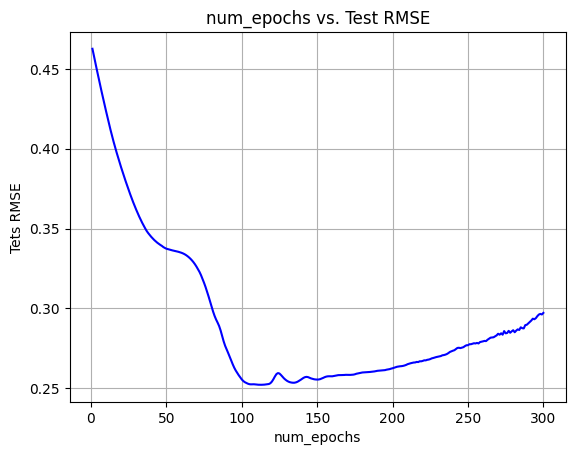

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.25227750308392505
Corresponding R^2 SCore: 0.4253976303066976
Corresponding num_epochs: 113


#### Test R^2 Score vs. num_epochs

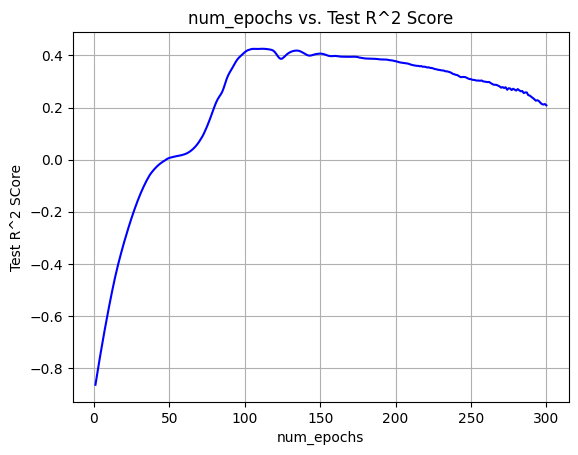

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.4256162415286072
Corresponding RMSE: 0.2523126423616388
Corresponding num_epochs: 111


#### Test Adjusted R^2 Score (Valence) vs. num_epochs

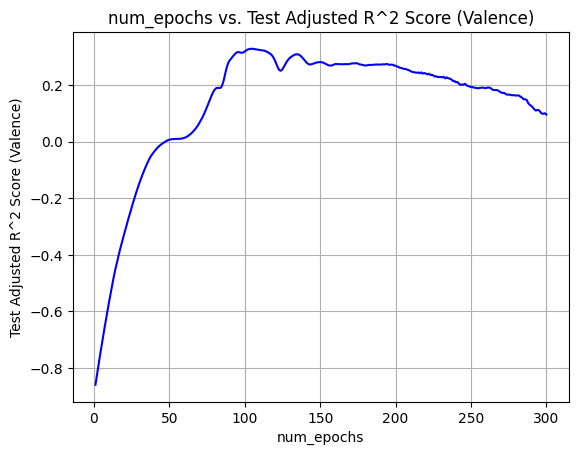

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.32755437900100015
Corresponding RMSE: 0.2529794396503264
Corresponding num_epochs: 104


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

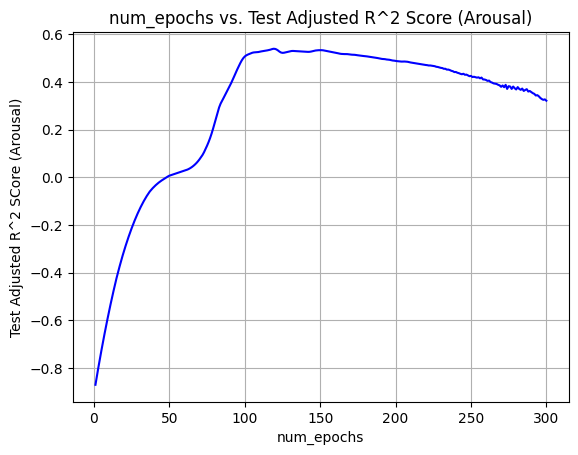

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5391498368109394
Corresponding RMSE: 0.2532653272218951
Corresponding num_epochs: 119
